In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

#from matplotlib import pyplot as plt
from util import util
#from scipy.integrate import odeint
#import numpy as np
#import pandas as pd
#from sklearn.metrics import r2_score
from tensorflow import keras
#from skopt.space import Space
#from eml.net.reader import keras_reader

# Motivation for Decision-Focused Learning

Remember that thing about the big picture?

## Prediction and Optimization in the Wild

**Real world problems typically rely on _estimated parameters_**

E.g. travel times, demands, item weights/costs...

<center><img src="assets/traffic.jpg" width="70%"/></center>

**However, sometimes we have access to _a bit more information_**

## Prediction and Optimization in the Wild

**Take _traffic-dependent travel times_ as an example**

If we know the _time of the day_ we can probably estimate them better

<center><img src="assets/traffic.jpg" width="70%"/></center>

**Let's see how these problems are typically addressed**

## Predict, then Optimize

**First, we _train an estimator_ for the problem parameters:**

$$
\text{argmin}_{\omega} \left\{L(y, \hat{y}) \mid y = f(\hat{x}; \omega) \right\}
$$
* $L$ is the loss function
* $f$ is the ML model with parameter 
* $\hat{x}$, $\hat{y}$ are the training set input/output

**In our example:**

* $x$ would be the time of the day
* $y$ would be a vector of travel times
* $L$ may be a classical MSE loss
* $f$ may be a linear regressor or neural network

## Predict, then Optimize

**Then, we solve the optimization problem with the estimated parameters**

$$
z^*(y) = \text{argmin}_z \left\{ c(z, y) \mid z \in F(y) \right\}
$$
* $z$ is the vector of variables of the optimization problem
* $c$ is the cost function
* $F$ is the feasible space
* In general, both $c$ and $F$ may depend on the estimated parameters

**In our example**

* $z$ may represent routing decisions
* $c$ may be the total travel time
* $F$ may encode a deadline constraint

## Predict, then Optimize

**This approach is sometimes referred to as "Predict, then Optimize"**

It is simple and it makes intuitively sense

* The more accurate we are, the better we will estimate the parameters
* ...And in turn we should get better optimization results

**Let $L^*(\hat{y})$ be the best possible loss value, for any ML model**

* For any reasonable loss function, _better training leads to better predictions_

$$
y \xrightarrow[L(y, \hat{y}) \rightarrow L^*(\hat{y})]{} y^*
$$

* ...And therefore, eventually we are _guaranteed to find the best solution_

$$
z^*(y) \xrightarrow[L(y, \hat{y}) \rightarrow L^*(\hat{y})]{} z^*(\hat{y})
$$

## "Predict, then Optimize": Limitations

**However, things are not really that simple!**

> **Why is that the case?**

The relation:

$$
z^*(y) \xrightarrow[L(y, \hat{y}) \rightarrow L^*(\hat{y})]{} z^*(\hat{y})
$$

...Holds only _asymptotically_

* In practice, our model may not be capable of reaching mimimum loss
* ...And this is even more true for unseen example

In this situation, it is unclear _how imperfect predictions impact the cost_

## "Predict, then Optimize": Limitations

**Say we want to move from location A to B, using one of two routes**

Based on the time of the day (x-axis)

<center class='smalltext'>
<img src="assets/spo_example_1.png" width="45%"/>
Image from <a href="https://arxiv.org/abs/1710.08005">"Smart Predict, then Optimize"</a>
</center>

...The travel time changes (y-axis)

## "Predict, then Optimize": Limitations

**We need to pick the best route**

<center class='smalltext'>
<img src="assets/spo_example_1.png" width="45%"/>
Image from <a href="https://arxiv.org/abs/1710.08005">"Smart Predict, then Optimize"</a>
</center>

* The dashed line shows the input value that causes the optimal choice to switch

## "Predict, then Optimize": Limitations

**If we train an optimal Linear Regression, we get these estimates**

<center><img src="assets/spo_example_2.png" width="40%"/></center>

* The estimator is most accurate possible
* ...But we get the switching point _wrong_!

## "Predict, then Optimize": Limitations

**By contrast, consider this second estimator**

<center><img src="assets/spo_example_3.png" width="40%"/></center>

* The accuracy is awful
* ...But we get the switching point _right_!

## Decision Focused Learning

**Addressing these issues is the goal of _decision focused learning_**

* The general idea is to _account for the optimization problem_ during training
* ...And the "holy grail" of the DFL is solving:

$$
\text{argmin}_{\omega} \left\{ \sum_{i=1}^m c(z^*(y_i), \hat{y}_i) \mid y = f(\hat{x}, \omega) \right\}
$$

* The field was kicked off by [this paper](https://arxiv.org/abs/1703.04529)
* ...And many other have followed

A good entry point are [the works by prof. Guns](https://dblp.org/pid/41/3130.html) and references therein

**Before discussing DFL, however, let's establish a baseline**

# A Baseline Approach

We'll need to do better than this

## Target Problem

**We will consider an "optimal purchase" problem**

Given a set of objects with values $v_i$ and cost $y_i$

* We need to buy items for a value of at least $v_{min}$
* ...While minimizing the purchase cost

This is essentially the dual of the classical knapsack problem

**The costs depend on the market state**

I.e. we have:

$$
y = f(x)
$$

* We will assume that the market state if captured by a single number
* ...And that historical data is available for training an estimator

## Dataset Generation

**We will start by generating a training set**

We will assume that the dependency on $x$ is captured by sigmoid curves

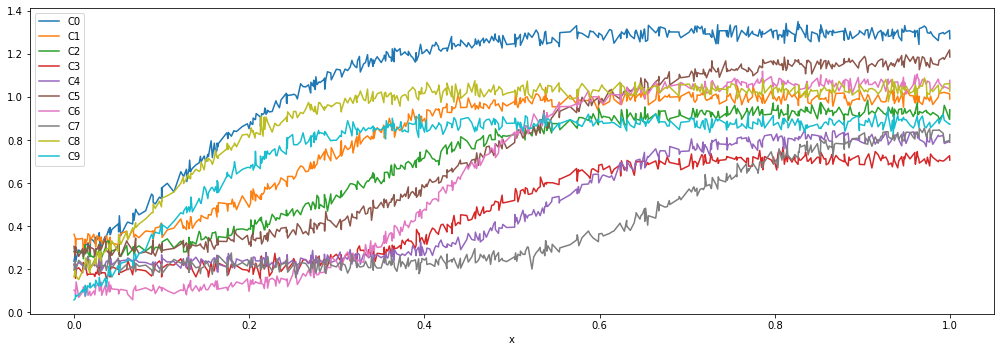

In [2]:
nitems, nsamples = 10, 500
data = util.generate_market_dataset(nsamples, nitems, seed=2, noise=.02)
util.plot_df_cols(data, figsize=figsize)

## Dataset Generation

**Let's check the dataset structure**

In [3]:
data.head()

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9
x,,,,,,,,,,
0.000124,0.237339,0.362793,0.283177,0.223027,0.223313,0.306461,0.103802,0.196172,0.164807,0.058347
0.001541,0.273677,0.346396,0.269355,0.204457,0.221878,0.261104,0.099676,0.241537,0.195367,0.063215
0.001883,0.235295,0.298894,0.282876,0.158408,0.218716,0.304677,0.080486,0.190402,0.183731,0.081783
0.002583,0.250008,0.341717,0.278371,0.200027,0.218275,0.298575,0.142006,0.204406,0.167427,0.073985
0.005544,0.290177,0.340446,0.279034,0.207337,0.232551,0.260204,0.070202,0.241806,0.152773,0.081679


* The input value is stored as the index
* Each `CX` column refers to the cost for a given item
* $x$ naturally ranges in $[0, 1]$, while the costs are not normalized
* ...But their range is fine enough to avoid issues with gradient descent

## Data Preparation

**Therefore, we just need to split our data for training and test**

In [4]:
data_tr, data_ts = util.train_test_split(data, test_size=0.3, seed=42)
print(f'#Examples: {len(data_tr)} (training), {len(data_ts)} (test)')

#Examples: 350 (training), 150 (test)


We do not have many examples

* This is actually fairly realistic
* ...Since it's not easy to collect instances for decision problems

**Next, we separate input and output**

In [5]:
tr_in, tr_out = data_tr.index.values, data_tr.values
ts_in, ts_out = data_ts.index.values, data_ts.values

## Building a ML Estimator

**We will train a _linear regression_ model**

* This is on purpose: the strong bias in the model
* ...Will prevent a very accurate approximation of the data

...So that we get some mistakes even for this very simple problem

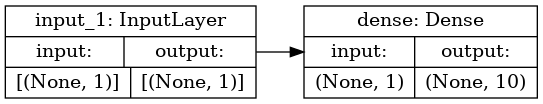

In [6]:
fsm_early = util.build_ml_model(input_size=1, output_size=nitems, hidden=[], name='FSM', output_activation='linear')
util.plot_ml_model(fsm_early)

* Specifically, we have one linear regressor per item

## Training the Estimator

**We will investigate early and later convergence**

Therefore, let's make a first training attempt for just a few epochs

INFO:tensorflow:Assets written to: fsm_early/assets


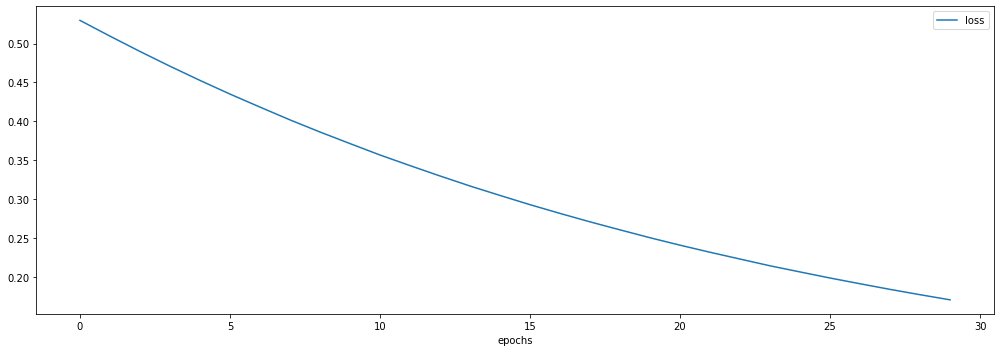

Model loss: 0.1703 (training)


In [7]:
history = util.train_ml_model(fsm_early, tr_in, tr_out, epochs=30, validation_split=0)
fsm_early.save('fsm_early')
util.plot_training_history(history, figsize=figsize)

## Training the Estimator

**We will investigate early and later convergence**

...And then let's train to (approximate) convergence

INFO:tensorflow:Assets written to: fsm_late/assets


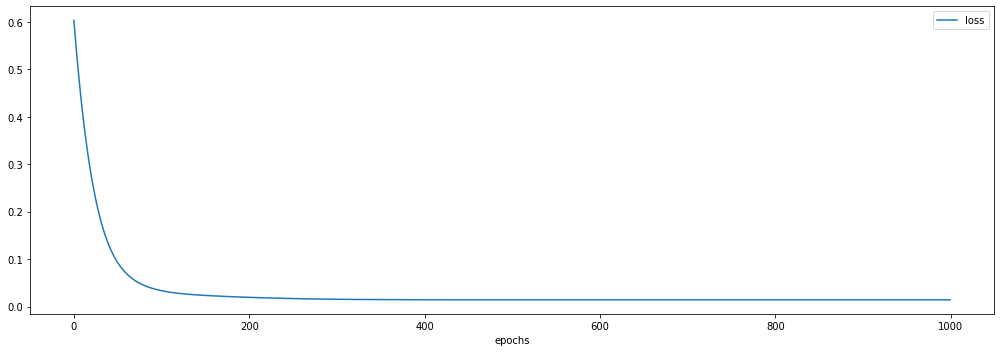

Model loss: 0.0143 (training)


In [8]:
fsm_late = keras.models.clone_model(fsm_early)
history = util.train_ml_model(fsm_late, tr_in, tr_out, epochs=1000, validation_split=0)
fsm_late.save('fsm_late')
util.plot_training_history(history, figsize=figsize)

## Evaluating the Estimator

**Let's evaluate the accuracy of the two models**

Here are the metrics for the "early" stage of training:

In [9]:
r2, mae, rmse = util.get_ml_metrics(fsm_early, tr_in, tr_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (training)')
r2, mae, rmse = util.get_ml_metrics(fsm_early, ts_in, ts_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (test)')

R2: -1.39, MAE: 0.3, RMSE: 0.41 (training)
R2: -1.46, MAE: 0.3, RMSE: 0.41 (test)


...And here for the "late" stage:

In [10]:
r2, mae, rmse = util.get_ml_metrics(fsm_late, tr_in, tr_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (training)')
r2, mae, rmse = util.get_ml_metrics(fsm_late, ts_in, ts_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (test)')

R2: 0.79, MAE: 0.097, RMSE: 0.12 (training)
R2: 0.78, MAE: 0.1, RMSE: 0.12 (test)


## Solving the Optimization Problem

**The predictions $y = f(x)$ are used to solve an optimization problem**

...Which can be stated in the form:

$$
\text{argmin}_z \{ y^T z \mid \|z\| \geq v_{min}, z \in \{0, 1\}^n \}
$$

* This is Integer Linear Program (ILP)
* ...Which we tackle in our code using Or-tools/CBC:

```python
slv = pywraplp.Solver.CreateSolver('CBC')
x = [slv.IntVar(0, 1, f'x_{i}') for i in range(nv)]
rcst = slv.Add(sum(values[i] * x[i] for i in range(nv)) >= req)
slv.Minimize(sum(costs[i] * x[i] for i in range(nv)))
```

The code is wrapped in the class `MarketProblem`

## Solving the Optimization Problem

**First, let's generate an instance where we need to select 50% of the items**

In [11]:
prb = util.generate_market_problem(nitems=nitems, rel_req=0.5, seed=42)

Then, let's check the solution for two distinct market states:

In [12]:
costs = data.iloc[0]
print('costs:', ', '.join(f'{v:.2}' for v in costs))
sol, closed = prb.solve(costs, tlim=10, print_solution=True)

costs: 0.24, 0.36, 0.28, 0.22, 0.22, 0.31, 0.1, 0.2, 0.16, 0.058
Selected items: 3, 6, 7, 8, 9
Cost: 2.16, Value: 5.57, Requirement: 5.52, Closed: True


In [13]:
costs = data.iloc[200]
print('costs:', ', '.join(f'{v:.2}' for v in costs))
sol, closed = prb.solve(costs, tlim=10, print_solution=True)

costs: 1.2, 0.85, 0.68, 0.34, 0.27, 0.54, 0.38, 0.24, 1.0, 0.84
Selected items: 1, 3, 4, 6, 7
Cost: 6.32, Value: 5.53, Requirement: 5.52, Closed: True


## Regret

**Using an accuracy metric for our estimator has lots of limits**

This is basically the point of our current line of reasoning ;-)

* Now that we have a solver for our optimization problem
* We can evaluate our estimator in terms of regret

**By _regret_ we mean the _cost difference_ w.r.t. the true solution**

For the $i$-th example, this is given by:

$$
\hat{y}_i^{T} z(y_i) - \hat{y}_i^{T} z(\hat{y}_i) \quad \text{ with } y_i=f(x_i)
$$

* $\hat{y}_i$ is the true cost vector
* $z(\hat{y}_i)$ is the true optimal solution
* $z(y_i)$ is the optimal solution for the predicted costs

## Regret

**Let's check the regret on the training and test set**

We'll do this for the _"early"_ model...

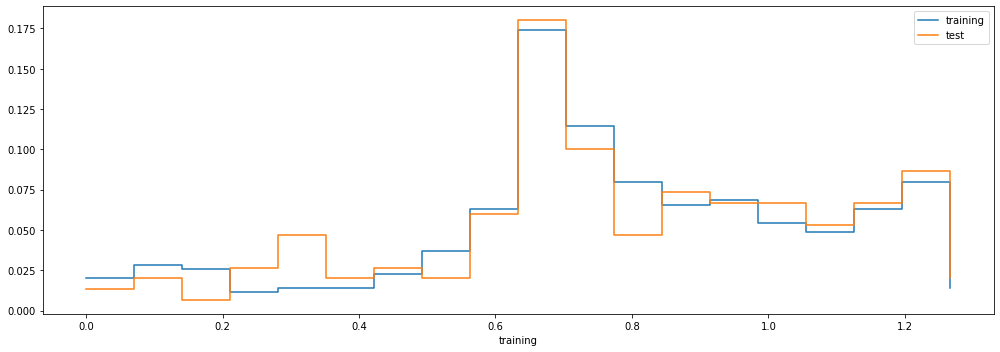

Mean: 0.774 (training), 0.785 (test)


In [14]:
r_tr = util.compute_regret(prb, fsm_early, tr_in, tr_out)
r_ts = util.compute_regret(prb, fsm_early, ts_in, ts_out)
util.plot_histogram(r_tr, figsize=figsize, label='training', data2=r_ts, label2='test', print_mean=True)

## Regret

**Let's check the regret on the training and test set**

...And for the _"late"_ one

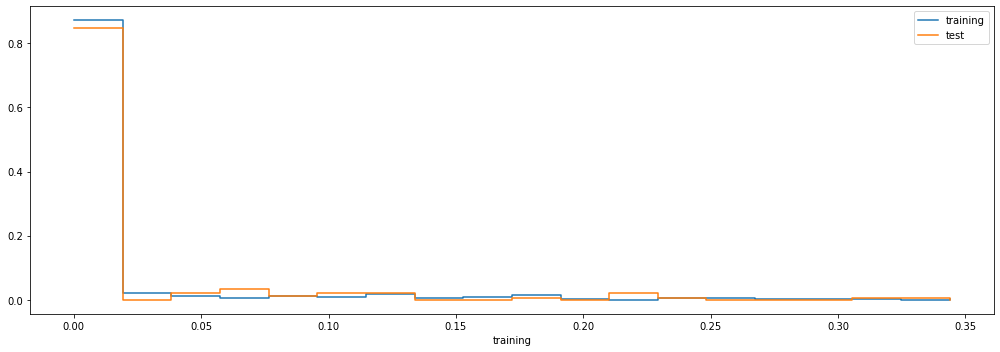

Mean: 0.017 (training), 0.020 (test)


In [15]:
r_tr = util.compute_regret(prb, fsm_late, tr_in, tr_out)
r_ts = util.compute_regret(prb, fsm_late, ts_in, ts_out)
util.plot_histogram(r_tr, figsize=figsize, label='training', data2=r_ts, label2='test', print_mean=True)